In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import functools
import pprint

import clu.checkpoint
import jax
import jax.numpy as jnp
import sqlalchemy as sa
import seaborn as sns
sns.set_style('whitegrid')
import pandas as pd
import matplotlib.pyplot as plt

from userdiffusion import samplers, unet
from userfm import cs, datasets, diffusion, sde_diffusion, utils, main as main_module

2025-01-09 20:43:48.257586: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736455428.276145    6163 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736455428.281761    6163 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/root/workspace/GitHub/pmlr-v202-finzi23a/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
engine = cs.get_engine()
cs.create_all(engine)
session = cs.orm.Session(engine)
session.begin()

In [4]:
config_alt_ids = [
    'hzjgor8s',
    '7m9h6qzi',
    'wnhx20xn',
]

In [5]:
cfgs = session.execute(sa.select(cs.Config).where(cs.Config.alt_id.in_(config_alt_ids)))
cfgs = [c for (c,) in cfgs]
reference_cfg = cfgs[0]

key = jax.random.key(reference_cfg.rng_seed)
key, key_dataset = jax.random.split(key)
ds = datasets.get_dataset(reference_cfg.dataset, key=key_dataset)
data_std = ds.Zs[reference_cfg.dataset.batch_size:].std()

cfg_info = {}
for cfg in cfgs:
    assert cfg.rng_seed == reference_cfg.rng_seed
    assert cfg.dataset == reference_cfg.dataset

    cfg_unet = unet.unet_64_config(
        ds.Zs.shape[-1],
        base_channels=cfg.model.architecture.base_channel_count,
        attention=cfg.model.architecture.attention,
    )
    model = unet.UNet(cfg_unet)
    # just create params, restore saved weights later
    params = model.init(
        jax.random.key(0),
        x=ds.Zs[:cfg.dataset.batch_size],
        t=jnp.zeros(cfg.dataset.batch_size),
        train=False,
        cond=main_module.condition_on_initial_time_steps(ds.Zs[:reference_cfg.dataset.batch_size], cfg.dataset.time_step_count_conditioning),
    )
    ckpt = clu.checkpoint.MultihostCheckpoint(str(cfg.run_dir/'model-checkpoints'), {}, max_to_keep=2)
    ema_params = ckpt.restore(params)

    cfg_info[cfg.alt_id] = dict(
        cfg=cfg,
        model=model,
        ema_params=ema_params,
    )

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.02it/s]
/root/workspace/GitHub/pmlr-v202-finzi23a/.venv/lib/python3.10/site-packages/jax/_src/numpy/linalg.py:1343: FutureWarning: jnp.linalg.solve: batched 1D solves with b.ndim > 1 are deprecated, and in the future will be treated as a batched 2D solve. Use solve(a, b[..., None])[..., 0] to avoid this warning.
  warnings.warn("jnp.linalg.solve: batched 1D solves with b.ndim > 1 are deprecated, "
I0000 00:00:1736455459.843477    6163 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4229 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1a:00.0, compute capability: 8.6


In [17]:
# evaluation_trajectories = ds.Zs[reference_cfg.dataset.batch_size:][:reference_cfg.dataset.batch_size]
evaluation_trajectories = ds.Zs[:reference_cfg.dataset.batch_size]

In [19]:
cond = main_module.condition_on_initial_time_steps(evaluation_trajectories, reference_cfg.dataset.time_step_count_conditioning)
trajectory_count = reference_cfg.dataset.batch_size
for config_alt_id, info in cfg_info.items():
    cfg = info['cfg']
    key, key_samples = jax.random.split(key)
    if isinstance(cfg.model, cs.ModelDiffusion):
        @jax.jit
        def score(x, t):
            if not hasattr(t, 'shape') or not t.shape:
                t = jnp.ones(x.shape[0]) * t
            return diffusion.score(info['model'], info['ema_params'], difftype, data_std, x, t, train=False, cond=cond)
            
        difftype = sde_diffusion.get_sde_diffusion(cfg.model.sde_diffusion)
        samples = samplers.sde_sample(difftype, score, key_samples, x_shape=ds.Zs[:trajectory_count].shape, nsteps=1_000)
        info['difftype'] = difftype
        info['samples'] = samples
    elif isinstance(cfg.model, cs.ModelFlowMatching):
        @jax.jit
        def velocity(x, t):
            if not hasattr(t, 'shape') or not t.shape:
                t = jnp.ones(x.shape[0]) * t
            return -info['model'].apply(info['ema_params'], x=x, t=t, train=False, cond=cond)
        
        samples = samplers.ode_sample_taos(velocity, 1., key_samples, x_shape=ds.Zs[:trajectory_count].shape, nsteps=1_000)
        info['samples'] = samples
    else:
        raise ValueError(f'Unknown model: {cfg.model}')

In [20]:
for info in cfg_info.values():
    info['relative_error'] = main_module.relative_error(evaluation_trajectories, info['samples'])

In [21]:
info['relative_error'].shape

(500, 60)

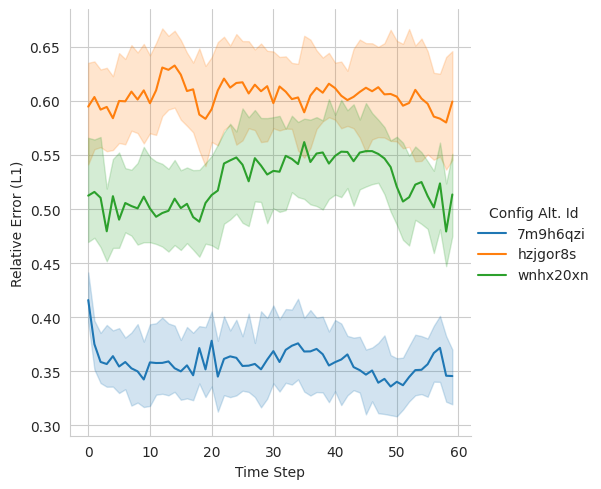

In [33]:
for info in cfg_info.values():
    df = (
        pd.DataFrame(info['relative_error'])
        .melt(var_name='Time Step', value_name='Relative Error (L1)')
    )
    info['relative_error_df'] = df
df = pd.concat([
    info['relative_error_df']
    for info in cfg_info.values()
], keys=cfg_info, names=['Config Alt. Id']).reset_index('Config Alt. Id')
sns.relplot(
    kind='line',
    estimator='median',
    data=df,
    x='Time Step',
    y='Relative Error (L1)',
    hue='Config Alt. Id',
)

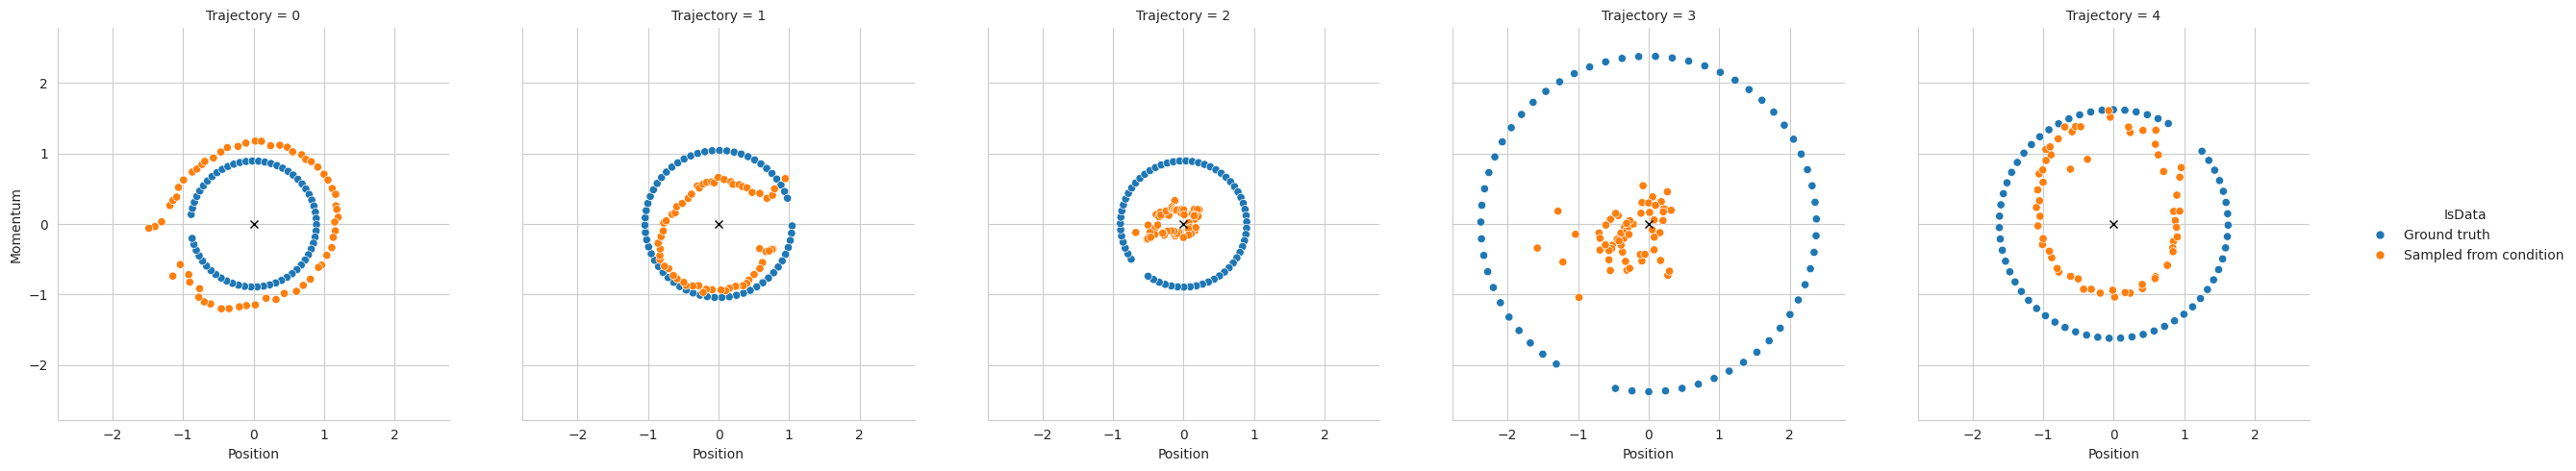

In [29]:
# config_alt_id = 'hzjgor8s'
config_alt_id = '7m9h6qzi'
# config_alt_id = 'wnhx20xn'
trajectory_count = 5
df = pd.concat([
    *[
        pd.DataFrame(dict(
            IsData='Ground truth', Trajectory=str(i), Position=evaluation_trajectories[i, :, 0], Momentum=evaluation_trajectories[i, :, 1]
        ))
        for i in range(trajectory_count)
    ],
    *[
        pd.DataFrame(dict(
            IsData='Sampled from condition', Trajectory=str(i), Position=cfg_info[config_alt_id]['samples'][i, :, 0], Momentum=cfg_info[config_alt_id]['samples'][i, :, 1]
        ))
        for i in range(trajectory_count)
    ],
]).reset_index(names=['Time Step'])
share_axes = True
plot = sns.relplot(
    data=df,
    x='Position', y='Momentum',
    hue='IsData',
    col='Trajectory',
    facet_kws=dict(
        sharex=share_axes,
        sharey=share_axes,
    )
)
xmax, ymax = df[['Position', 'Momentum']].max(axis=0) + .4
for (row, col, hue), data in plot.facet_data():
    ax = plot.axes[row][col]
    if not share_axes:
        xmax, ymax = data[['Position', 'Momentum']].max(axis=0) + .4
    ax.set_xlim(xmin=-xmax, xmax=xmax)
    ax.set_ylim(ymin=-ymax, ymax=ymax)
    ax.set_aspect('equal')
    ax.plot([0], [0], 'kx')

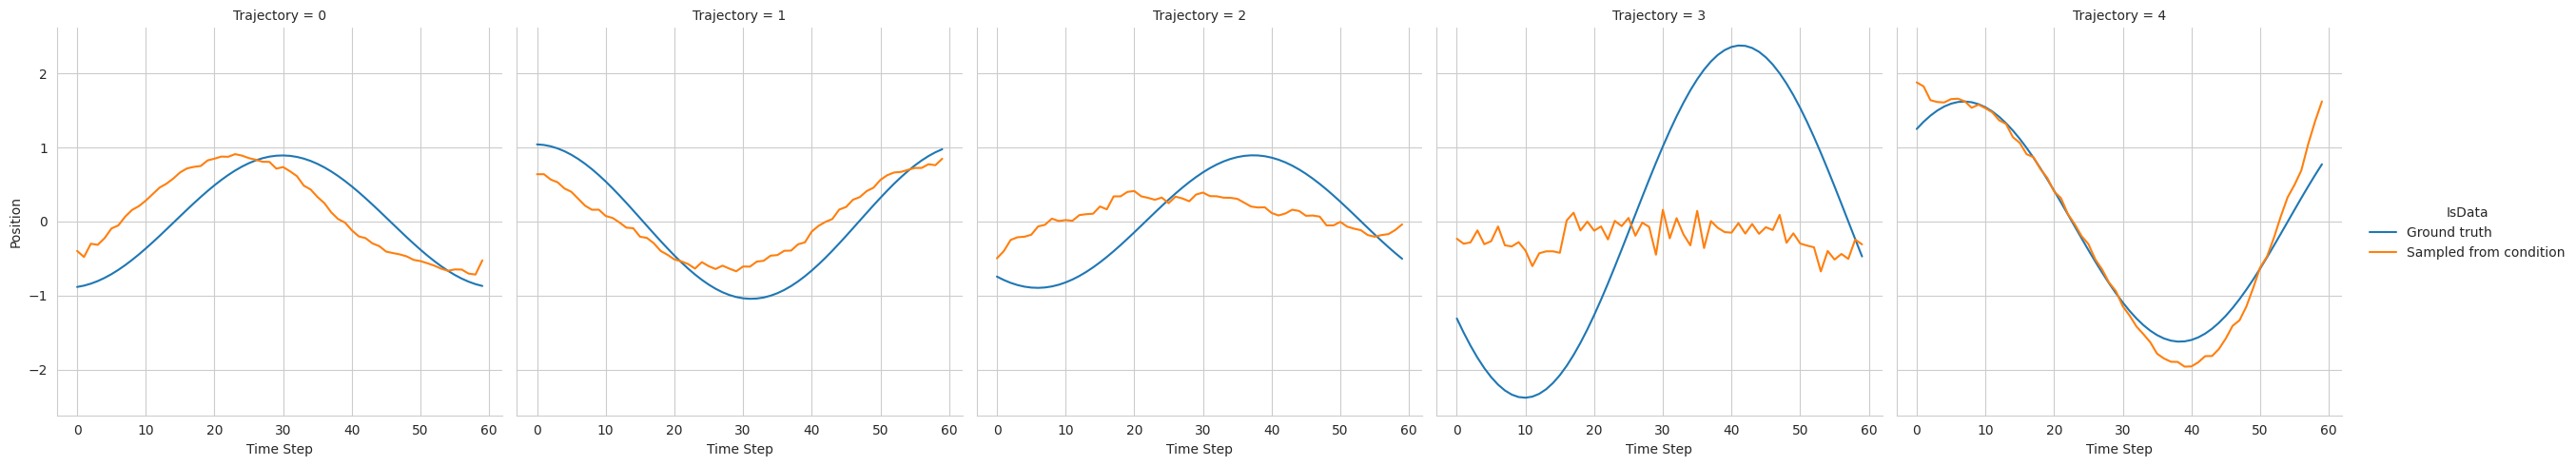

In [25]:
sns.relplot(
    kind='line',
    data=df,
    x='Time Step',
    y='Position',
    hue='IsData',
    col='Trajectory'
)

In [26]:
# session.close()